In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def calculate_payout(current_price, grant_price, allocation):
    payout = 0
    payout_funcs = {
        "cash": payout_cash,
        "rsus": payout_rsus,
        "atm_options": payout_atm_options,
        "otm_options": payout_otm_options,
    }
    for equity_type, amount in allocation.items():
        payout += payout_funcs[equity_type](current_price, grant_price, amount=amount)
    return payout


def payout_cash(current_price, grant_price, amount, discount=0.1):
    return amount * (1 - discount)

def payout_rsus(current_price, grant_price, amount):
    return (amount / grant_price) * current_price

def payout_atm_options(current_price, grant_price, amount, immediate_exercise=False):
    n_options = (amount / grant_price) * 4
    if immediate_exercise:
        # this possibility is not considered in the blog post, but is included for illustration
        return n_options * np.maximum(current_price - grant_price, 0)
    else:
        return n_options * np.maximum(current_price[-1] - grant_price, 0)

def payout_otm_options(current_price, grant_price, amount, immediate_exercise=False):
    n_options = (amount / grant_price) * 8
    if immediate_exercise:
        # this possibility is not considered in the blog post, but is included for illustration
        return n_options * np.maximum(current_price - 1.5 * grant_price, 0)
    else:
        return n_options * np.maximum(current_price[-1] - 1.5 * grant_price, 0)

STRATEGIES = {
    "cash_only": {
        "cash": 1,
    },
    "rsus_only": {
        "rsus": 1,
    },
    "atm_only": {
        "atm_options": 1,
    },
    "otm_only": {
        "otm_options": 1,
    },
    "default": {
        "rsus": 0.75,
        "atm_options": 0.25,
    },
    "rsus_cash": {
        "rsus": 0.5,
        "cash": 0.5,
    },
    "rsus_options": {
        "rsus": 0.5,
        "atm_options": 0.25,
        "otm_options": 0.25,
    },
    "even": {
        "cash": 0.25,
        "rsus": 0.25,
        "atm_options": 0.25,
        "otm_options": 0.25
    }
}

def get_allocation(strategy, amount):
    frac_allocation = STRATEGIES[strategy]
    return {
        equity_type: frac * amount for equity_type, frac in frac_allocation.items()
    }

In [3]:
class SimulationRunner:
    def __init__(self, mu, sigma, n_steps, allocation, price=1):
        self.mu = mu
        self.sigma = sigma
        self.n_steps = n_steps
        self.payouts = []
        self.grant_price = price
        self.price = price
        self.allocation = allocation
        
    def advance_step(self):
        drift = np.random.normal()
        rate_of_return = np.exp(self.mu - 1/2*self.sigma**2 + sigma*drift)
        self.price *= rate_of_return
        # note: this does not work with options since the exercise event is not at time t
        payout = calculate_payout(
            current_price=self.price,
            grant_price=self.grant_price,
            allocation=self.allocation
        )
        self.payouts.append(payout)
        
    def run(self) -> np.array:
        for i in range(self.n_steps):
            self.advance_step()
        return np.array(self.payouts)

In [4]:
class SimulationRunnerVectorized:
    def __init__(self, mu, sigma, n_steps, allocation, price=1):
        self.mu = mu
        self.sigma = sigma
        self.n_steps = n_steps
        self.grant_price = price
        self.price = price
        self.allocation = {
            equity_type: np.ones(n_steps, ) * amount
            for equity_type, amount in allocation.items()
        }
        
    def compute_prices(self):
        drift = np.random.normal(size=(self.n_steps,))
        rate_of_return = np.exp(self.mu - 1/2*self.sigma**2 + sigma*drift)
        prices = self.price*np.cumprod(rate_of_return)
        return prices
        
    def run(self):
        prices = self.compute_prices()
        payouts = calculate_payout(
            current_price=prices,
            grant_price=self.grant_price,
            allocation=self.allocation
        )
        return payouts

In [5]:
results = []
n_steps = 48
strategies = STRATEGIES.keys()
for strategy in strategies:
    print(strategy)
    allocation = get_allocation(strategy, amount=1/n_steps)
    for mu in np.linspace(-0.25/n_steps, 0.5/n_steps, 21):
        for sigma in np.linspace(0, 2/n_steps, 21):
            for i in range(1000):
                payouts = SimulationRunnerVectorized(
                    mu=mu, sigma=sigma, n_steps=n_steps, allocation=allocation
                ).run()
                results.append({
                    "mu": mu,
                    "sigma": sigma,
                    "trial": i,
                    "strategy": strategy,
                    "payout": payouts.sum()
                })
results = pd.DataFrame(results)

cash_only
rsus_only
atm_only
otm_only
default
rsus_cash
rsus_options
even


In [7]:
results.head()

,mu,sigma,trial,strategy,payout
0,-0.005208,0.0,0,cash_only,0.9
1,-0.005208,0.0,1,cash_only,0.9
2,-0.005208,0.0,2,cash_only,0.9
3,-0.005208,0.0,3,cash_only,0.9
4,-0.005208,0.0,4,cash_only,0.9


In [6]:
def postprocess_for_strategy(results, strategy, quantile=None):
    grouped = (
        results
        .query("strategy == @strategy")
        .groupby(by=['mu', 'sigma'])['payout']
    )
    if quantile is None:
        return grouped.mean().reset_index()
    else:
        return grouped.quantile(quantile).reset_index()

In [8]:
def contour_data(frame):
    Z = pd.pivot_table(frame, index='mu', columns='sigma', values='payout').T.values
    X_unique = 12 * np.sort(frame['mu'].unique())
    Y_unique = 12 * np.sort(frame['sigma'].unique())
    X, Y = np.meshgrid(X_unique, Y_unique)
    return X, Y, Z

def plot(results, strategy, quantile):
    frame = postprocess_for_strategy(results, strategy=strategy, quantile=quantile)
    fig = plt.figure(figsize=(8, 6))
    ax = fig.gca()
    X, Y, Z = contour_data(frame)
    cp = ax.contourf(X, Y, Z, levels=np.linspace(0, 3, 11))
    ax.set_xlabel('mu * 12', fontsize = 14)
    ax.set_ylabel('sigma * 12', fontsize = 14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    cbar = fig.colorbar(cp);
    cbar.ax.tick_params(labelsize=12)
    ax.set_title(f"STRATEGY: {strategy.replace('_', ' ').title()}", fontsize=14)
    return fig

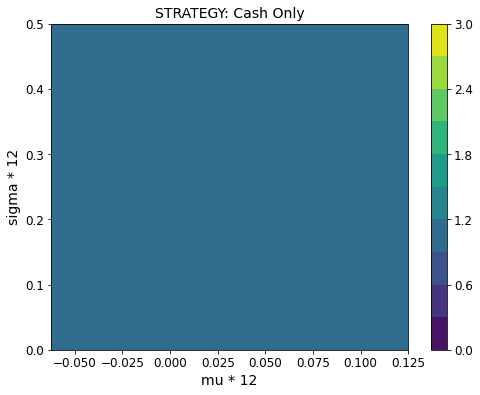

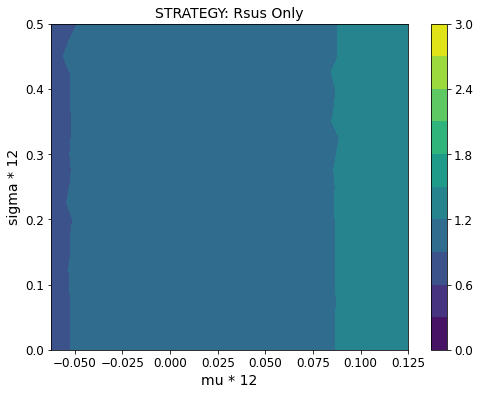

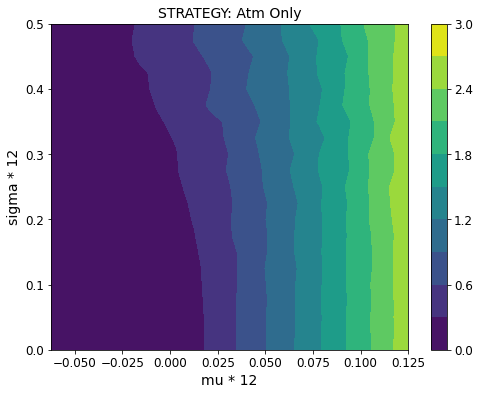

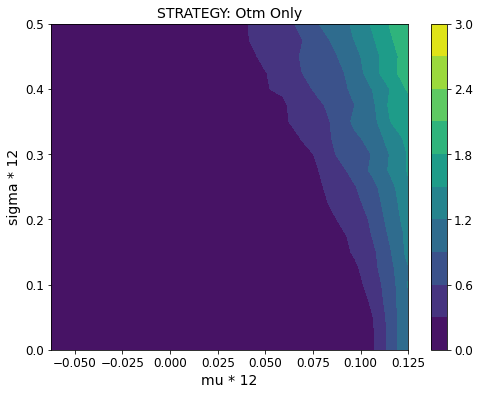

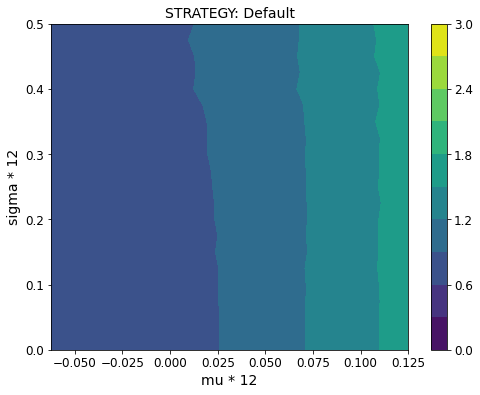

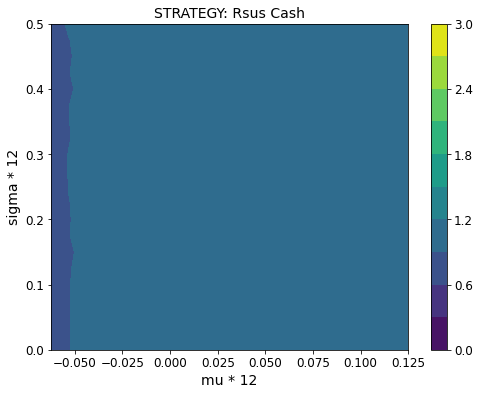

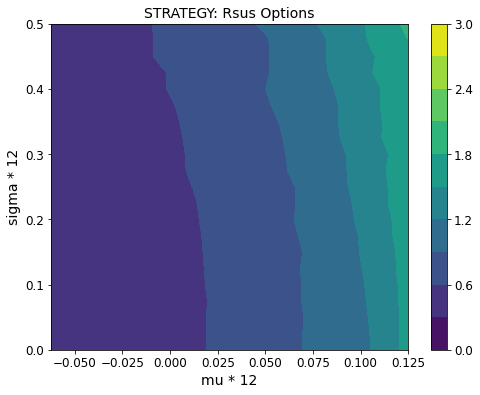

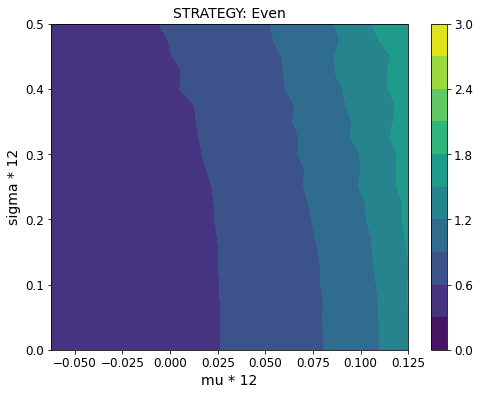

In [9]:
for strategy in STRATEGIES.keys():
    plot(results, strategy=strategy, quantile=None);

(array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

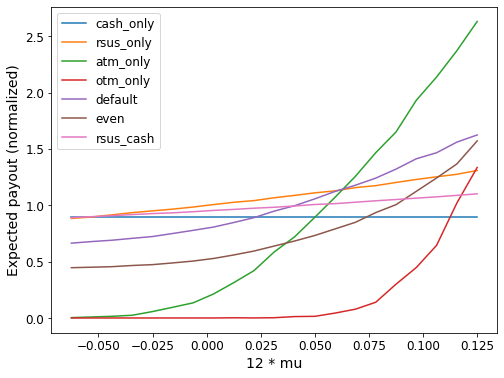

In [10]:
fig = plt.figure(figsize=(8, 6))
ax = fig.gca()
for strategy in ['cash_only', 'rsus_only', 'atm_only', 'otm_only', 'default', 'even', 'rsus_cash']:
    frame = postprocess_for_strategy(results, strategy=strategy, quantile=None)
    frame = frame.query("sigma == 0.2/12")
    ax.plot(frame["mu"] * 12, frame["payout"], label=strategy)
plt.legend(fontsize=12)
ax.set_xlabel('12 * mu', fontsize = 14)
ax.set_ylabel('Expected payout (normalized)', fontsize = 14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
